In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
import seaborn as sns
import warnings
import datetime as dt
from datetime import timedelta
warnings.filterwarnings('ignore')

sns.set()

## 5B.1 Feature Selection

In [2]:
%store -r feature_sarima

In [3]:
# create a combination of feature
# for the second model, we may incorporate SARIMA components, such as trend, forecast, and lagged values into the model
# After some trial and error, incorporating third lagged values and trend makes the simplest model without sacrificing metrics
# While resale_year and resale_month can be removed as their role has been replaced by SARIMA components

feat = feature_sarima.drop(['resale_quarter','resale_month', 'resale_year', 'lag1', 'lag2', 'lag4', 'trend'], axis = 1)
feat.shape

# Here we have 10 variables, including the target

(152529, 9)

In [4]:
feat.head()

,resale_price,resale_date,lease_commence_year,storey_range,town,flat_model,floor_area_sqm,sarima_forecast,lag3
7925,233000.0,2017-06-01,1986,2,ANG MO KIO,IMPROVED,45.0,443652.372539,447295.950889
7926,250000.0,2017-06-01,1978,2,ANG MO KIO,IMPROVED,44.0,443652.372539,447295.950889
7927,235000.0,2017-06-01,1976,2,ANG MO KIO,NEW GENERATION,67.0,443652.372539,447295.950889
7928,260000.0,2017-06-01,1980,2,ANG MO KIO,NEW GENERATION,68.0,443652.372539,447295.950889
7929,260000.0,2017-06-01,1981,0,ANG MO KIO,NEW GENERATION,68.0,443652.372539,447295.950889


## 5B.2 Model Building

In [5]:
dummies = pd.get_dummies(feat, drop_first= True, prefix_sep= '--') #create dummy variables
dummies.head()

# After creating dummy variables, the variables becomes 53, including the target
# Much simpler than those of baseline model

,resale_price,resale_date,lease_commence_year,storey_range,floor_area_sqm,sarima_forecast,lag3,town--BEDOK,town--BISHAN,town--BUKIT BATOK,...,flat_model--MULTI GENERATION,flat_model--NEW GENERATION,flat_model--PREMIUM APARTMENT,flat_model--PREMIUM APARTMENT LOFT,flat_model--PREMIUM MAISONETTE,flat_model--SIMPLIFIED,flat_model--STANDARD,flat_model--TERRACE,flat_model--TYPE S1,flat_model--TYPE S2
7925,233000.0,2017-06-01,1986,2,45.0,443652.372539,447295.950889,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7926,250000.0,2017-06-01,1978,2,44.0,443652.372539,447295.950889,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7927,235000.0,2017-06-01,1976,2,67.0,443652.372539,447295.950889,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7928,260000.0,2017-06-01,1980,2,68.0,443652.372539,447295.950889,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7929,260000.0,2017-06-01,1981,0,68.0,443652.372539,447295.950889,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [6]:
feature_sarima.groupby('resale_year').size().cumsum() / len(feature_sarima) * 100

# we use the same train-test split as that in baseline model

resale_year
2017      8.133535
2018     22.257407
2019     36.786447
2020     52.060264
2021     71.101889
2022     88.600201
2023    100.000000
dtype: float64

In [7]:
# Here I pick Aug 2022 as the limit of train dataset (1 year before the last date)
# Which is close to 80:20 split

cutoff_date = 'Aug 2022'
filter_year = dummies['resale_date'] <= cutoff_date
dummies = dummies.drop(['resale_date'], axis = 1) #drop resale_date because it is unusable in the model
train = dummies[filter_year] # training dataset
test = dummies[~filter_year] # testing dataset

In [8]:
len(test)/len(train)

0.20816006463417533

In [9]:
X_train = train.iloc[:, 1:] # training predictors
X_test = test.iloc[:, 1:] # testing predictors
y_train = train.iloc[:, 0] # training target
y_test = test.iloc[:, 0] # testing target

In [10]:
import statsmodels.api as sm

LinearRegression = sm.OLS(y_train, sm.add_constant(X_train)).fit()
LR_summary = LinearRegression.summary()
print(LR_summary)

# From the summary below, we get the R-squared of 87.7%, a 1.7% increase from that of baseline model
# The predictors p-values also indicate that those feature are mostly statistically significant

                            OLS Regression Results                            
Dep. Variable:           resale_price   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                 1.786e+04
Date:                Tue, 24 Oct 2023   Prob (F-statistic):               0.00
Time:                        11:59:01   Log-Likelihood:            -1.5633e+06
No. Observations:              126249   AIC:                         3.127e+06
Df Residuals:                  126198   BIC:                         3.127e+06
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

## 5B.3 Visual Evaluation

In [11]:
# create prediction based on training dataset
y_train_pred = LinearRegression.predict(sm.add_constant(X_train))
y_train_pred_df = pd.concat([feature_sarima['resale_date'], y_train_pred], axis = 1)

In [12]:
# create prdiction based on testing dataset
y_test_pred = LinearRegression.predict(sm.add_constant(X_test))
y_test_pred_df = pd.concat([feature_sarima['resale_date'], y_test_pred], axis = 1)

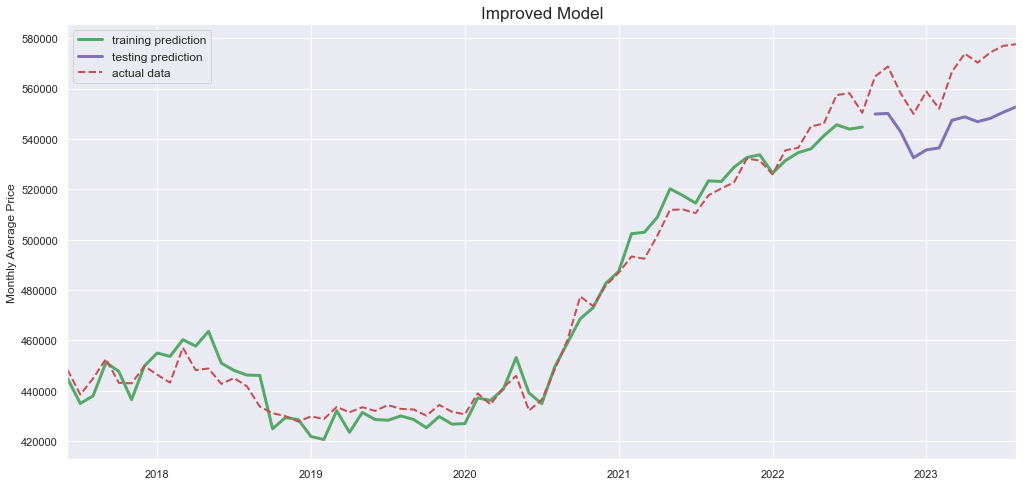

In [13]:
# Compare the training and testing predictions with actual dataset
fontsize1 = 17
fontsize2 = 12

plt.figure(figsize=[17,8])
y_train_pred_df.groupby('resale_date')[0].mean().plot(color = 'g', label = 'training prediction', linewidth = 3)
y_test_pred_df.groupby('resale_date')[0].mean().plot(color = 'm', label = 'testing prediction', linewidth = 3)
feature_sarima.groupby('resale_date')['resale_price'].mean().plot(color = 'r', label = 'actual data', linestyle = '--', linewidth = 2)
plt.legend(fontsize = fontsize2)
plt.title('Improved Model', fontsize = fontsize1)
plt.xlabel('', fontsize = fontsize2)
plt.ylabel('Monthly Average Price', fontsize = fontsize2)
plt.savefig('Improved Model Graph.png');

# From the graph below, we can tell that our second model can capture trend and seasonality well
# Although the test prediction exhibits larger errors than train prediction does

In [14]:
train_residual = y_train_pred - y_train
test_residual = y_test_pred - y_test

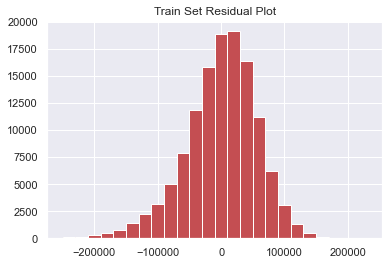

In [15]:
bins = np.arange(-250000, 250000, 20000)
plt.hist(train_residual, color = 'r', bins = bins)
plt.title('Train Set Residual Plot')
plt.show();

In [16]:
train_residual.mean()

#close to zero

2.9242880360647132e-06

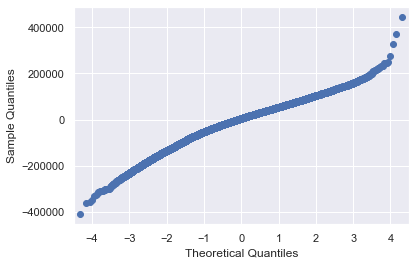

In [17]:
sm.qqplot(train_residual);

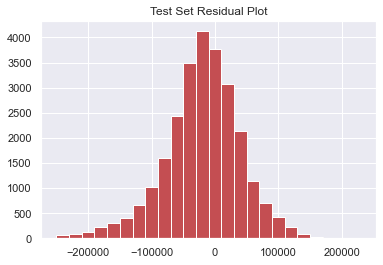

In [18]:
plt.hist(test_residual, color = 'r', bins = bins)
plt.title('Test Set Residual Plot')
plt.show();

In [19]:
test_residual.mean()

# Still far from zero, but much better than that of baseline model

-20834.392060199174

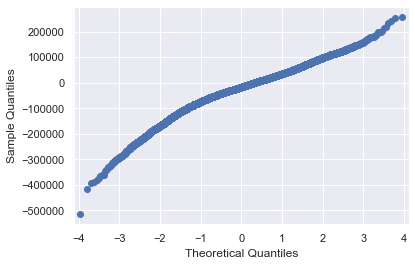

In [20]:
sm.qqplot(test_residual);

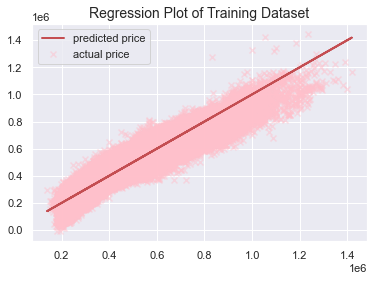

In [21]:
sns.set()
plt.scatter(y_train, y_train_pred, marker = 'x', color = 'pink', alpha = 0.5, label = 'actual price')
plt.plot(y_train, y_train, linewidth = 2, label = 'predicted price', color = 'r')
plt.title('Regression Plot of Training Dataset', fontsize = 14)
plt.legend()
plt.show()

# based on the plot below, we can observe that the values are scattered relatively evenly around the regression line
# it looks homoscedastic enough

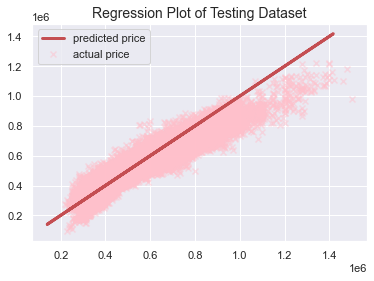

In [22]:
plt.scatter(y_test, y_test_pred, marker = 'x', alpha = 0.5, color = 'pink', label = 'actual price')
plt.plot(y_train, y_train, color = 'r', linewidth = 3, label = 'predicted price')
plt.title('Regression Plot of Testing Dataset', fontsize = 14)
plt.legend()
plt.show()

## 5B.4 Metrics Evaluation

In [23]:
print(f'R-Squared = {LinearRegression.rsquared*100:.3f} %')
print(f'R-Squared Adjusted = {LinearRegression.rsquared_adj*100:.3f} %')

R-Squared = 87.616 %
R-Squared Adjusted = 87.611 %


In [24]:
from sklearn.metrics import mean_absolute_error as MAE

test_MAE = MAE(y_test, y_test_pred)
train_MAE = MAE(y_train, y_train_pred)
delta_MAE = (test_MAE - train_MAE)/train_MAE*100

In [25]:
mean_resale_price = feature_sarima.groupby('resale_date')['resale_price'].mean()

In [26]:
# We can see that in this model, the MAE of testing dataset dropped dramatically compared to that of baseline
# from 62002 to 47185

print(f'Mean of Actual Monthly Resale Price: ', f'SGD {mean_resale_price.mean():.2f}')
print(f'MAE of test dataset: ', f'{test_MAE:.2f}')
print(f'MAE of train dataset: ', f'{train_MAE:.2f}')
print(f'MAE change: ', f'{delta_MAE:.2f}'+'%')

Mean of Actual Monthly Resale Price:  SGD 483783.74
MAE of test dataset:  48700.58
MAE of train dataset:  44451.25
MAE change:  9.56%


In [27]:
from sklearn.metrics import mean_squared_error as MSE

test_MSE = MSE(y_test, y_test_pred)
train_MSE = MSE(y_train, y_train_pred)
delta_MSE = (test_MSE - train_MSE)/train_MSE*100

In [28]:
print(f'MSE of test dataset: ', f'{test_MSE:.3f}')
print(f'MSE of train dataset: ', f'{train_MSE:.3f}')
print(f'MSE change: ', f'{delta_MSE:.2f}'+'%')

MSE of test dataset:  4314919795.732
MSE of train dataset:  3333034991.060
MSE change:  29.46%
